In [1]:
from utils import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Import resampling modules from imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


# Question

1. What should be the minimum duration of we want to classify?

In [2]:
# trajectories_df = load_filtered_data(years=('2019',), folder='../AIS_data', min_data_points=100)

# def sort_row(row):
#     # load into arrays
#     e  = np.asarray(row['elapsed_s'])
#     la = np.asarray(row['LAT'])
#     lo = np.asarray(row['LON'])
#     # get the sort‐order
#     idx = np.argsort(e)
#     # return a Series so apply(...) will build a DataFrame with matching columns
#     return pd.Series({
#         'elapsed_s': e[idx],
#         'LAT'      : la[idx],
#         'LON'      : lo[idx]
#     })

# # apply and overwrite in one go
# trajectories_df[['elapsed_s','LAT','LON']] = trajectories_df.apply(sort_row, axis=1)

trajectories_df = pd.read_pickle('../AIS_preprocessed_data/trajectories_2019.pkl')

In [3]:
trajectories_df

,MMSI,elapsed_s,LAT,LON,VesselType,Label
0,367659930,"[0, 69, 138, 210, 279, 349, 420, 488, 570, 639...","[30.4289, 30.42774, 30.42675, 30.42573, 30.424...","[-87.99302, -87.99258, -87.9919, -87.99129, -8...",31.0,0
1,367553360,"[0, 70, 149, 220, 301, 379, 449, 559, 630, 709...","[29.01648, 29.01666, 29.01664, 29.01661, 29.01...","[-91.83069, -91.83175, -91.83304, -91.83416, -...",30.0,0
2,367461560,"[0, 64, 134, 204, 274, 354, 425, 495, 45847, 4...","[29.36644, 29.36952, 29.37291, 29.3762, 29.379...","[-91.38801, -91.38525, -91.38225, -91.37948, -...",90.0,0
3,538007067,"[0, 120, 301, 483, 662, 843, 1023, 1204, 1383,...","[28.82299, 28.82325, 28.8236, 28.82388, 28.824...","[-89.33299, -89.33357, -89.3343, -89.33491, -8...",70.0,0
4,369053000,"[0, 70, 139, 209, 270, 340, 410, 473, 540, 610...","[30.18058, 30.17847, 30.17641, 30.17425, 30.17...","[-88.56405, -88.56745, -88.57083, -88.57432, -...",90.0,0
...,...,...,...,...,...,...
296782,538006166,"[0, 81, 224, 301, 401, 510, 581, 651, 750, 831...","[28.91509, 28.91185, 28.90624, 28.90286, 28.89...","[-89.42226, -89.42518, -89.43059, -89.43154, -...",80.0,0
296783,538005865,"[0, 69, 130, 337, 440, 620, 681, 811, 891, 104...","[28.91911, 28.91597, 28.91333, 28.90537, 28.90...","[-89.4197, -89.422, -89.4239, -89.43129, -89.4...",80.0,0
296784,369293000,"[0, 100, 230, 309, 391, 480, 741, 811, 879, 90...","[29.07654, 29.07338, 29.06873, 29.06566, 29.06...","[-90.22863, -90.22913, -90.22987, -90.23059, -...",90.0,0
296785,636017526,"[0, 90, 161, 240, 307, 433, 498, 565, 636, 715...","[30.64235, 30.63707, 30.63251, 30.6274, 30.622...","[-88.03225, -88.03235, -88.03236, -88.03249, -...",70.0,0


In [3]:
trajectories_df.shape

(296787, 6)

In [4]:
trajectories_df.columns

Index(['MMSI', 'elapsed_s', 'LAT', 'LON', 'VesselType', 'Label'], dtype='object')

In [5]:
counts = trajectories_df['Label'].value_counts()
print(counts)


Label
0    295090
1      1697
Name: count, dtype: int64


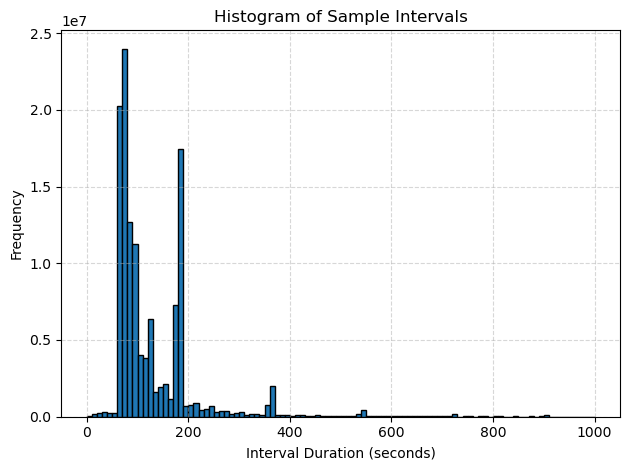

In [6]:
# Step 1: Flatten all sample intervals from all trajectories
all_intervals = []

for elapsed in trajectories_df['elapsed_s']:
    elapsed = np.array(elapsed)
    if len(elapsed) > 1:
        # intervals = np.diff(np.sort(elapsed))  # ensure time is sorted
        intervals = np.diff(elapsed)
        valid_intervals = intervals[(intervals <= 1000)]  # filter
        all_intervals.extend(valid_intervals)
        # all_intervals.extend(intervals)
all_intervals = np.array(all_intervals)
import matplotlib.pyplot as plt
plt.figure()
plt.hist(all_intervals, bins=100, edgecolor='black')
plt.title("Histogram of Sample Intervals")
plt.xlabel("Interval Duration (seconds)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [3]:
# import numpy as np
# import pandas as pd

# # threshold in seconds
# THRESHOLD = 3600

# def split_row_into_segments(row, threshold=THRESHOLD):
#     """
#     Given a row with list‐columns ['elapsed_s','LAT','LON'],
#     split into multiple segments whenever elapsed_s gaps > threshold.
#     Returns a list of dicts, each dict is one sub-trajectory.
#     """
    
#     e  = row['elapsed_s']
#     la = row['LAT']
#     lo = row['LON']
    

#     # compute gaps and find break points
#     gaps = np.diff(e)
#     # break *after* any index i where gap[i] > threshold
#     break_idxs = np.where(gaps > threshold)[0]

#     # define segment boundaries: starts at 0, each break+1, ends at len(e)
#     boundaries = np.concatenate([[0], break_idxs + 1, [len(e)]])

#     segments = []

#     e = np.asarray(e)
#     for start, end in zip(boundaries[:-1], boundaries[1:]):
#         seg = {
#             'MMSI':        row['MMSI'],
#             'VesselType':  row['VesselType'],
#             'Label':       row['Label'],
#             'elapsed_s':   e[start:end]-e[start],  # normalize to start at 0
#             'LAT':         la[start:end],
#             'LON':         lo[start:end],
#         }
#         # only keep segments with at least two points
#         if len(seg['elapsed_s']) > 100:
#             segments.append(seg)
#     return segments

# # apply to all rows and flatten
# all_segments = []
# for _, row in trajectories_df.iterrows():
#     all_segments.extend(split_row_into_segments(row))

# # build new DataFrame
# segmented_df = pd.DataFrame(all_segments)

# # reset index if you like
# segmented_df = segmented_df.reset_index(drop=True)
# segmented_df.to_pickle('../AIS_preprocessed_data/segmented_trajectories_2019.pkl')

# Load the segmented DataFrame
segmented_df = pd.read_pickle('../AIS_preprocessed_data/segmented_trajectories_2019.pkl')
print(segmented_df.shape)


(301706, 6)


In [5]:
trajectories_df['Label'].value_counts()

Label
0    295090
1      1697
Name: count, dtype: int64

In [6]:
segmented_df['Label'].value_counts()

Label
0    300108
1      1598
Name: count, dtype: int64

In [7]:
segmented_df

,MMSI,VesselType,Label,elapsed_s,LAT,LON
0,367659930,31.0,0,"[0, 69, 138, 210, 279, 349, 420, 488, 570, 639...","[30.4289, 30.42774, 30.42675, 30.42573, 30.424...","[-87.99302, -87.99258, -87.9919, -87.99129, -8..."
1,367553360,30.0,0,"[0, 70, 149, 220, 301, 379, 449, 559, 630, 709...","[29.01648, 29.01666, 29.01664, 29.01661, 29.01...","[-91.83069, -91.83175, -91.83304, -91.83416, -..."
2,367461560,90.0,0,"[0, 65, 131, 197, 263, 335, 402, 467, 533, 600...","[29.38964, 29.38584, 29.38206, 29.37743, 29.37...","[-91.36791, -91.37142, -91.37496, -91.37891, -..."
3,538007067,70.0,0,"[0, 120, 301, 483, 662, 843, 1023, 1204, 1383,...","[28.82299, 28.82325, 28.8236, 28.82388, 28.824...","[-89.33299, -89.33357, -89.3343, -89.33491, -8..."
4,369053000,90.0,0,"[0, 70, 139, 209, 270, 340, 410, 473, 540, 610...","[30.18058, 30.17847, 30.17641, 30.17425, 30.17...","[-88.56405, -88.56745, -88.57083, -88.57432, -..."
...,...,...,...,...,...,...
301701,538006166,80.0,0,"[0, 81, 224, 301, 401, 510, 581, 651, 750, 831...","[28.91509, 28.91185, 28.90624, 28.90286, 28.89...","[-89.42226, -89.42518, -89.43059, -89.43154, -..."
301702,538005865,80.0,0,"[0, 69, 130, 337, 440, 620, 681, 811, 891, 104...","[28.91911, 28.91597, 28.91333, 28.90537, 28.90...","[-89.4197, -89.422, -89.4239, -89.43129, -89.4..."
301703,369293000,90.0,0,"[0, 100, 230, 309, 391, 480, 741, 811, 879, 90...","[29.07654, 29.07338, 29.06873, 29.06566, 29.06...","[-90.22863, -90.22913, -90.22987, -90.23059, -..."
301704,636017526,70.0,0,"[0, 90, 161, 240, 307, 433, 498, 565, 636, 715...","[30.64235, 30.63707, 30.63251, 30.6274, 30.622...","[-88.03225, -88.03235, -88.03236, -88.03249, -..."


# Random Forrest with handcrafted classifier

In [4]:
# import numpy as np
# import pandas as pd
# from scipy.stats import mode

# # Fast haversine distance (vectorized) in meters
# def haversine_np(lat1, lon1, lat2, lon2):
#     R = 6371000  # Radius of Earth in meters
#     lat1 = np.radians(lat1)
#     lon1 = np.radians(lon1)
#     lat2 = np.radians(lat2)
#     lon2 = np.radians(lon2)
    
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
    
#     a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
#     c = 2 * np.arcsin(np.sqrt(a))
#     return R * c

# def extract_features(row):
#     elapsed = np.array(row['elapsed_s'])
#     lat = np.array(row['LAT'])
#     lon = np.array(row['LON'])

#     # Vectorized distance computation
#     distances = haversine_np(lat[:-1], lon[:-1], lat[1:], lon[1:])  # shape: (n-1,)
    
#     dt = np.diff(elapsed) + 1e-10 # shape: (n-1,)
#     speed = distances / dt  # shape: (n-1,)
#     acceleration = np.diff(speed) / dt[1:]  # shape: (n-2,)

#     def extract_stats(arr):
#         return [
#             np.mean(arr),
#             np.max(arr),
#             np.min(arr),
#             np.std(arr),
#             mode(arr, keepdims=False).mode,
#             np.percentile(arr, 25),
#             np.percentile(arr, 50),
#             np.percentile(arr, 75)
#         ]

#     stat_names = ['mean', 'max', 'min', 'std', 'mode', 'q1', 'q2', 'q3']
#     feature_names = []
#     for prefix in ['speed', 'distance', 'acceleration', 'time_gap','lat', 'lon']:
#         feature_names.extend([f"{prefix}_{s}" for s in stat_names])

#     feature_values = (
#         extract_stats(speed)
#         + extract_stats(distances)
#         + extract_stats(acceleration)
#         + extract_stats(dt)
#         + extract_stats(lat)
#         + extract_stats(lon)
#     )

#     return pd.DataFrame([feature_values], columns=feature_names)
# # Apply feature extraction to each row
# features_df = pd.concat(segmented_df.apply(extract_features, axis=1).tolist(), ignore_index=True)


# features_df.to_pickle('../AIS_preprocessed_data/features_trajectories_2019.pkl')
# Load the features DataFrame
features_df = pd.read_pickle('../AIS_preprocessed_data/features_trajectories_2019.pkl')

In [5]:
features_df['Label'] = segmented_df['Label'].values

In [10]:
features_df.to_csv('../AIS_preprocessed_data/features_trajectories_2019.csv', index=False)

In [6]:
features_df

,speed_mean,speed_max,speed_min,speed_std,speed_mode,speed_q1,speed_q2,speed_q3,distance_mean,distance_max,...,lat_q3,lon_mean,lon_max,lon_min,lon_std,lon_mode,lon_q1,lon_q2,lon_q3,Label
0,1.849572,2.044116,1.495934,0.090731,1.839331,1.795889,1.856550,1.911966,135.071257,264.140849,...,30.362690,-87.903259,-87.76132,-87.99302,0.068003,-87.99302,-87.960960,-87.922550,-87.848695,0
1,1.243128,4.468756,0.000000,1.325308,0.000000,0.030436,1.227719,1.544401,145.142859,2841.874087,...,29.020655,-91.502626,-91.23235,-91.85809,0.224377,-91.32419,-91.768765,-91.328140,-91.324105,0
2,1.754980,10.152139,0.000000,3.110417,0.000000,0.024849,0.244928,1.120400,120.601385,2065.622075,...,29.247860,-91.404438,-91.36791,-91.47050,0.028035,-91.39651,-91.410160,-91.396490,-91.387170,0
3,0.054933,0.528916,0.004212,0.048892,0.024173,0.026561,0.045788,0.065964,10.568758,81.068426,...,28.822770,-89.333770,-89.33024,-89.33521,0.001293,-89.33479,-89.334740,-89.334340,-89.333300,0
4,3.108983,7.442290,0.000000,2.851432,0.015885,0.255487,2.427915,6.065710,216.861544,2717.328784,...,30.180550,-88.744727,-88.54420,-88.88934,0.131171,-88.88031,-88.879640,-88.776920,-88.601815,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301701,6.299446,6.930492,4.685812,0.522108,4.685812,5.944622,6.576137,6.680766,681.770504,2844.183786,...,28.798198,-89.308369,-89.08625,-89.43154,0.104131,-89.43154,-89.416560,-89.323005,-89.211875,0
301702,6.189746,6.821701,3.443472,0.644929,3.443472,6.044247,6.441361,6.587360,574.446311,1785.005854,...,28.790492,-89.325142,-89.16524,-89.43129,0.079961,-89.42653,-89.414905,-89.320230,-89.266795,0
301703,5.137518,5.654067,3.547199,0.304828,3.547199,4.949292,5.138249,5.344579,537.621115,1376.406977,...,28.964675,-90.096276,-89.84271,-90.23363,0.116995,-90.23363,-90.207423,-90.126710,-90.001112,0
301704,7.070819,8.183824,5.002604,0.481781,5.002604,6.905803,7.075561,7.343370,665.507580,2086.436941,...,30.479425,-88.062989,-88.01349,-88.25952,0.060417,-88.03209,-88.077433,-88.032710,-88.024760,0


In [ ]:
# import numpy as np
# import pandas as pd
# from scipy.stats import mode

# # Fast haversine distance (vectorized) in meters
# def haversine_np(lat1, lon1, lat2, lon2):
#     R = 6371  # Radius of Earth in meters
#     lat1 = np.radians(lat1)
#     lon1 = np.radians(lon1)
#     lat2 = np.radians(lat2)
#     lon2 = np.radians(lon2)
    
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
    
#     a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
#     c = 2 * np.arcsin(np.sqrt(a))
#     return R * c

# def extract_features(row):
#     elapsed = np.array(row['elapsed_s'])
#     lat = np.array(row['LAT'])
#     lon = np.array(row['LON'])

#     # Vectorized distance computation
#     distances = haversine_np(lat[:-1], lon[:-1], lat[1:], lon[1:])  # shape: (n-1,)
    
#     dt = (np.diff(elapsed) + 1e-10)/60 # shape: (n-1,)


#     speed = distances / dt  # shape: (n-1,)
#     acceleration = np.diff(speed) / dt[1:]  # shape: (n-2,)


#     break_duration = 0 # G1
#     trip_duration = elapsed[-1] - elapsed[0] # G2

#     # Mask for movement (speed > 0.1 km/min)
#     threshold = 0.1  # km/min
#     moving_mask = speed > threshold

#     # Euclidean distance and total distance while moving
#     euclidean_dist = np.sum(distances[moving_mask])
#     total_moving_dist = np.sum(distances[moving_mask])  # same here unless specified otherwise

#     # Movement efficiency (G3)
#     movement_efficiency = euclidean_dist / total_moving_dist if total_moving_dist > 0 else 0 # G3

#     trips_per_year = 0 # G4 (placeholder, needs actual logic to count trips per year)

#     # G5: Pings per Minute in Movement
#     pings_in_movement = np.sum(moving_mask)
#     time_in_movement = np.sum(elapsed[moving_mask])
#     pings_per_minute = pings_in_movement / time_in_movement if time_in_movement > 0 else 0 # G5

#     # What is a forward/backward trip?
    





    
# # Apply feature extraction to each row
# features_df = pd.concat(segmented_df.apply(extract_features, axis=1).tolist(), ignore_index=True)




In [ ]:
features_df.to_csv("data.csv", index=False)

In [5]:
features_df

,speed_mean,speed_max,speed_min,speed_std,speed_mode,speed_q1,speed_q2,speed_q3,distance_mean,distance_max,...,lat_q2,lat_q3,lon_mean,lon_max,lon_min,lon_std,lon_mode,lon_q1,lon_q2,lon_q3
0,1.849572,2.044116,1.495934,0.090731,1.839331,1.795889,1.856550,1.911966,135.071257,264.140849,...,30.301030,30.362690,-87.903259,-87.76132,-87.99302,0.068003,-87.99302,-87.960960,-87.922550,-87.848695
1,1.243128,4.468756,0.000000,1.325308,0.000000,0.030436,1.227719,1.544401,145.142859,2841.874087,...,28.999880,29.020655,-91.502626,-91.23235,-91.85809,0.224377,-91.32419,-91.768765,-91.328140,-91.324105
2,1.754980,10.152139,0.000000,3.110417,0.000000,0.024849,0.244928,1.120400,120.601385,2065.622075,...,29.243710,29.247860,-91.404438,-91.36791,-91.47050,0.028035,-91.39651,-91.410160,-91.396490,-91.387170
3,0.054933,0.528916,0.004212,0.048892,0.024173,0.026561,0.045788,0.065964,10.568758,81.068426,...,28.822280,28.822770,-89.333770,-89.33024,-89.33521,0.001293,-89.33479,-89.334740,-89.334340,-89.333300
4,3.108983,7.442290,0.000000,2.851432,0.015885,0.255487,2.427915,6.065710,216.861544,2717.328784,...,30.167670,30.180550,-88.744727,-88.54420,-88.88934,0.131171,-88.88031,-88.879640,-88.776920,-88.601815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301701,6.299446,6.930492,4.685812,0.522108,4.685812,5.944622,6.576137,6.680766,681.770504,2844.183786,...,28.651085,28.798198,-89.308369,-89.08625,-89.43154,0.104131,-89.43154,-89.416560,-89.323005,-89.211875
301702,6.189746,6.821701,3.443472,0.644929,3.443472,6.044247,6.441361,6.587360,574.446311,1785.005854,...,28.638040,28.790492,-89.325142,-89.16524,-89.43129,0.079961,-89.42653,-89.414905,-89.320230,-89.266795
301703,5.137518,5.654067,3.547199,0.304828,3.547199,4.949292,5.138249,5.344579,537.621115,1376.406977,...,28.839210,28.964675,-90.096276,-89.84271,-90.23363,0.116995,-90.23363,-90.207423,-90.126710,-90.001112
301704,7.070819,8.183824,5.002604,0.481781,5.002604,6.905803,7.075561,7.343370,665.507580,2086.436941,...,30.299550,30.479425,-88.062989,-88.01349,-88.25952,0.060417,-88.03209,-88.077433,-88.032710,-88.024760


In [ ]:
# def extract_features(row):
#     elapsed = np.array(row['elapsed_s'])
#     lat = np.array(row['LAT'])
#     lon = np.array(row['LON'])

#     # Calculate duration
#     duration = elapsed[-1] - elapsed[0]

#     # Convert degrees to radians for Haversine formula
#     lat_rad = np.deg2rad(lat)
#     lon_rad = np.deg2rad(lon)

#     # Earth's radius (in km)
#     R = 6371.0

#     # Compute deltas
#     delta_lat = np.diff(lat_rad)
#     delta_lon = np.diff(lon_rad)

#     # Haversine formula
#     a = np.sin(delta_lat / 2.0) ** 2 + \
#         np.cos(lat_rad[:-1]) * np.cos(lat_rad[1:]) * np.sin(delta_lon / 2.0) ** 2
#     c = 2 * np.arcsin(np.sqrt(a))
#     distance = R * c  # distance between each consecutive point in km

#     # Time deltas (in seconds)
#     dt = np.diff(elapsed) + 1e-10
    

#     # Speed in km/h
#     # speeds = distance / (dt / 3600.0)
#     speeds = distance / dt

#     # Pad to align with original size
#     speeds = np.insert(speeds, 0, 0.0)

#     # Acceleration (km/h²)
#     accel = np.diff(speeds) / dt 
#     # accel = np.diff(speeds) / (dt[1:] / 3600.0) if len(speeds) > 1 else np.array([0.0])
#     accel = np.insert(accel, 0, 0.0)

#     return pd.Series({
#         'duration': duration,
#         'lat_mean': lat.mean(),
#         'lon_mean': lon.mean(),
#         'lat_std': lat.std(),
#         'lon_std': lon.std(),
#         'lat_median': np.median(lat),
#         'lon_median': np.median(lon),
#         'lat_min': lat.min(),
#         'lon_min': lon.min(),
#         'lat_max': lat.max(),
#         'lon_max': lon.max(),
#         'lat_range': lat.max() - lat.min(),
#         'lon_range': lon.max() - lon.min(),
#         'bbox_area': (lat.max() - lat.min()) * (lon.max() - lon.min()),
#         'start_lat': lat[0],
#         'start_lon': lon[0],
#         'end_lat': lat[-1],
#         'end_lon': lon[-1],
#         'speed_mean': speeds.mean(),
#         'speed_max': speeds.max(),
#         'speed_std': speeds.std(),
#         'accel_mean': accel.mean(),
#         'accel_std': accel.std(),
#         'accel_max': accel.max(),
#     })

# features = segmented_df.apply(extract_features, axis=1)

In [11]:
segmented_df

,MMSI,VesselType,Label,elapsed_s,LAT,LON
0,367659930,31.0,0,"[0, 69, 138, 210, 279, 349, 420, 488, 570, 639...","[30.4289, 30.42774, 30.42675, 30.42573, 30.424...","[-87.99302, -87.99258, -87.9919, -87.99129, -8..."
1,367553360,30.0,0,"[0, 70, 149, 220, 301, 379, 449, 559, 630, 709...","[29.01648, 29.01666, 29.01664, 29.01661, 29.01...","[-91.83069, -91.83175, -91.83304, -91.83416, -..."
2,367461560,90.0,0,"[0, 65, 131, 197, 263, 335, 402, 467, 533, 600...","[29.38964, 29.38584, 29.38206, 29.37743, 29.37...","[-91.36791, -91.37142, -91.37496, -91.37891, -..."
3,538007067,70.0,0,"[0, 120, 301, 483, 662, 843, 1023, 1204, 1383,...","[28.82299, 28.82325, 28.8236, 28.82388, 28.824...","[-89.33299, -89.33357, -89.3343, -89.33491, -8..."
4,369053000,90.0,0,"[0, 70, 139, 209, 270, 340, 410, 473, 540, 610...","[30.18058, 30.17847, 30.17641, 30.17425, 30.17...","[-88.56405, -88.56745, -88.57083, -88.57432, -..."
...,...,...,...,...,...,...
301701,538006166,80.0,0,"[0, 81, 224, 301, 401, 510, 581, 651, 750, 831...","[28.91509, 28.91185, 28.90624, 28.90286, 28.89...","[-89.42226, -89.42518, -89.43059, -89.43154, -..."
301702,538005865,80.0,0,"[0, 69, 130, 337, 440, 620, 681, 811, 891, 104...","[28.91911, 28.91597, 28.91333, 28.90537, 28.90...","[-89.4197, -89.422, -89.4239, -89.43129, -89.4..."
301703,369293000,90.0,0,"[0, 100, 230, 309, 391, 480, 741, 811, 879, 90...","[29.07654, 29.07338, 29.06873, 29.06566, 29.06...","[-90.22863, -90.22913, -90.22987, -90.23059, -..."
301704,636017526,70.0,0,"[0, 90, 161, 240, 307, 433, 498, 565, 636, 715...","[30.64235, 30.63707, 30.63251, 30.6274, 30.622...","[-88.03225, -88.03235, -88.03236, -88.03249, -..."


In [7]:
features_df

,speed_mean,speed_max,speed_min,speed_std,speed_mode,speed_q1,speed_q2,speed_q3,distance_mean,distance_max,...,lat_q3,lon_mean,lon_max,lon_min,lon_std,lon_mode,lon_q1,lon_q2,lon_q3,Label
0,1.849572,2.044116,1.495934,0.090731,1.839331,1.795889,1.856550,1.911966,135.071257,264.140849,...,30.362690,-87.903259,-87.76132,-87.99302,0.068003,-87.99302,-87.960960,-87.922550,-87.848695,0
1,1.243128,4.468756,0.000000,1.325308,0.000000,0.030436,1.227719,1.544401,145.142859,2841.874087,...,29.020655,-91.502626,-91.23235,-91.85809,0.224377,-91.32419,-91.768765,-91.328140,-91.324105,0
2,1.754980,10.152139,0.000000,3.110417,0.000000,0.024849,0.244928,1.120400,120.601385,2065.622075,...,29.247860,-91.404438,-91.36791,-91.47050,0.028035,-91.39651,-91.410160,-91.396490,-91.387170,0
3,0.054933,0.528916,0.004212,0.048892,0.024173,0.026561,0.045788,0.065964,10.568758,81.068426,...,28.822770,-89.333770,-89.33024,-89.33521,0.001293,-89.33479,-89.334740,-89.334340,-89.333300,0
4,3.108983,7.442290,0.000000,2.851432,0.015885,0.255487,2.427915,6.065710,216.861544,2717.328784,...,30.180550,-88.744727,-88.54420,-88.88934,0.131171,-88.88031,-88.879640,-88.776920,-88.601815,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301701,6.299446,6.930492,4.685812,0.522108,4.685812,5.944622,6.576137,6.680766,681.770504,2844.183786,...,28.798198,-89.308369,-89.08625,-89.43154,0.104131,-89.43154,-89.416560,-89.323005,-89.211875,0
301702,6.189746,6.821701,3.443472,0.644929,3.443472,6.044247,6.441361,6.587360,574.446311,1785.005854,...,28.790492,-89.325142,-89.16524,-89.43129,0.079961,-89.42653,-89.414905,-89.320230,-89.266795,0
301703,5.137518,5.654067,3.547199,0.304828,3.547199,4.949292,5.138249,5.344579,537.621115,1376.406977,...,28.964675,-90.096276,-89.84271,-90.23363,0.116995,-90.23363,-90.207423,-90.126710,-90.001112,0
301704,7.070819,8.183824,5.002604,0.481781,5.002604,6.905803,7.075561,7.343370,665.507580,2086.436941,...,30.479425,-88.062989,-88.01349,-88.25952,0.060417,-88.03209,-88.077433,-88.032710,-88.024760,0


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    classification_report
)


# --- Data Preparation ---
# Assuming 'features_df' and 'segmented_df' are already defined.
# If not, dummy data is created for demonstration purposes.

# X = features_df
time_cols = [c for c in features_df.columns if c.startswith("time")]
# X = features_df.drop(columns='Label')
# drop both Label and all those time-columns
X = features_df.drop(columns= time_cols)
y = segmented_df['Label']


# 1) Split into train+val (80%) and test (20%)
# Stratify ensures that the proportion of target variable 'y' is the same in all splits.
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.20,
    random_state=42
)

# 2) Split train+val into train (60%) and val (20%)
# Since X_temp is 80%, using test_size=0.25 on it gives 0.25 * 0.8 = 0.20 overall
X_train_orig, X_val, y_train_orig, y_val = train_test_split(
    X_temp, y_temp,
    stratify=y_temp,
    test_size=0.25,
    random_state=42
)

# Define the base classifier.
# class_weight='balanced' automatically adjusts weights inversely proportional to class frequencies.
base_clf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=100
)


In [9]:
# --- Function to Train, Tune Threshold, and Evaluate ---
def train_tune_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, classifier, sampling_strategy_name):
    """
    Trains a classifier, tunes its probability threshold on a validation set,
    and reports its performance on a test set.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training labels.
        X_val (pd.DataFrame): Validation features (for threshold tuning).
        y_val (pd.Series): Validation labels (for threshold tuning).
        X_test (pd.DataFrame): Test features (for final evaluation).
        y_test (pd.Series): Test labels (for final evaluation).
        classifier (sklearn.base.Estimator): The machine learning classifier to use.
        sampling_strategy_name (str): A descriptive name for the current sampling strategy
                                      (e.g., "Original Distribution", "Undersampled", "Oversampled").
    """
    print(f"\n{'='*50}\n--- Results for {sampling_strategy_name} Training Data ---\n{'='*50}")

    clf = classifier.__class__(**classifier.get_params()) # Create a fresh instance to avoid retraining issues
    
    # Train the classifier on the provided training data
    print(f"Training classifier on {len(X_train)} samples...")
    clf.fit(X_train, y_train)
    print("Training complete.")

    # Get probability scores for the validation set
    val_scores = clf.predict_proba(X_val)[:, 1]

    # Compute Precision-Recall curve to find the best threshold
    precision, recall, thresholds = precision_recall_curve(y_val, val_scores)

    # Calculate F1-score for each threshold to identify the optimal one
    # Add a small epsilon (1e-6) to prevent division by zero for F1 calculation
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-6)

    # Find the threshold that yields the highest F1-score on the validation set
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1_val = f1_scores[best_idx]

    print(f"\nBest validation threshold = {best_threshold:.4f} (F1-score = {best_f1_val:.4f})")

    # Evaluate the classifier on the unseen test set using the best threshold found
    test_scores = clf.predict_proba(X_test)[:, 1]
    y_test_pred = (test_scores >= best_threshold).astype(int)

    print(f"\n--- Classification Report on Test Set @ Threshold {best_threshold:.4f} ---")
    print(classification_report(y_test, y_test_pred))

    return clf


In [ ]:
import os
from joblib import dump

# make a directory for your models
os.makedirs("saved_models", exist_ok=True)

# Scenario 1: Original Distribution
model_orig = train_tune_evaluate(
    X_train_orig, y_train_orig,
    X_val, y_val,
    X_test, y_test,
    base_clf,
    "Original Distribution"
)
dump(model_orig, "saved_models/model_original_distribution.joblib")
print("Saved Original Distribution model to saved_models/model_original_distribution.joblib")

# Scenario 2: Undersampled Training Data
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_orig, y_train_orig)

model_under = train_tune_evaluate(
    X_train_under, y_train_under,
    X_val, y_val,
    X_test, y_test,
    base_clf,
    "Undersampled"
)
dump(model_under, "saved_models/model_undersampled.joblib")
print("Saved Undersampled model to saved_models/model_undersampled.joblib")

# Scenario 3: Oversampled Training Data
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train_orig, y_train_orig)

model_over = train_tune_evaluate(
    X_train_over, y_train_over,
    X_val, y_val,
    X_test, y_test,
    base_clf,
    "Oversampled"
)
dump(model_over, "saved_models/model_oversampled.joblib")
print("Saved Oversampled model to saved_models/model_oversampled.joblib")



--- Results for Original Distribution Training Data ---
Training classifier on 181023 samples...


In [21]:
from joblib import load
model = load("saved_models/model_undersampled.joblib")

In [23]:
print(np.__version__)
 # Check the type of the loaded model

2.2.4


In [24]:
import numpy, pandas, scipy, sklearn
print("NumPy:",  numpy.__version__)
print("Pandas:", pandas.__version__)
print("SciPy:",  scipy.__version__)
print("sklearn:", sklearn.__version__)


NumPy: 2.2.4
Pandas: 2.2.3
SciPy: 1.15.2
sklearn: 1.6.1


# Voting

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

# ── 0) Oversample if needed ───────────────────────────────────────────────────
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train_orig, y_train_orig)

# ── 1) Define base learners ────────────────────────────────────────────────────
# Tree-based
rf  = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
et  = ExtraTreesClassifier(n_estimators=50, n_jobs=-1, random_state=42)
gb  = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Distance-based
knn = KNeighborsClassifier(n_neighbors=5)

# Probabilistic
nb  = make_pipeline(StandardScaler(), GaussianNB())

# Linear / margin-based
lr  = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
# svm = make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True, random_state=42))

# ── 2) Voting ensemble ────────────────────────────────────────────────────────
voting_clf = VotingClassifier(
    estimators=[
        ("rf",  rf),
        ("et",  et),
        ("gb",  gb),
        ("knn", knn),
        ("nb",  nb),
        ("lr",  lr),
        # ("svm", svm),
    ],
    voting="soft",          # average predicted probabilities
    # weights=[2,1,1,1,1,1,1], # give RF a bit more say
    n_jobs=-1
)

# ── 3) Fit & evaluate ─────────────────────────────────────────────────────────
voting_clf.fit(X_train_over, y_train_over)




In [ ]:
# Get probability scores for the validation set
val_scores = voting_clf.predict_proba(X_val)[:, 1]
# val_scores = rf.predict_proba(X_val)[:, 1]

# Compute Precision-Recall curve to find the best threshold
precision, recall, thresholds = precision_recall_curve(y_val, val_scores)

# Calculate F1-score for each threshold to identify the optimal one
# Add a small epsilon (1e-6) to prevent division by zero for F1 calculation
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-6)

# Find the threshold that yields the highest F1-score on the validation set
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1_val = f1_scores[best_idx]

print(f"\nBest validation threshold = {best_threshold:.4f} (F1-score = {best_f1_val:.4f})")

# Evaluate the classifier on the unseen test set using the best threshold found
test_scores = voting_clf.predict_proba(X_test)[:, 1]
y_test_pred = (test_scores >= best_threshold).astype(int)

print(f"\n--- Classification Report on Test Set @ Threshold {best_threshold:.4f} ---")
print(classification_report(y_test, y_test_pred))

# Stacking

In [ ]:
# ── 3) Stacked Generalization ─────────────────────────────────────────────────
stack_clf = StackingClassifier(
    estimators=[("rf", rf), ("svm", svm), ("lr", lr)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    stack_method="predict_proba"
)

# Fit on train
stack_clf.fit(X_train_over, y_train_over)

# Evaluate on validation
y_val_pred_stack = stack_clf.predict(X_val)
print("Stacking Ensemble — Val Accuracy:", accuracy_score(y_val, y_val_pred_stack))
print(classification_report(y_val, y_val_pred_stack))

# ── 4) Final Test-Set Evaluation ─────────────────────────────────────────────
for name, model, y_pred in [
    ("Voting", voting_clf, voting_clf.predict(X_test)),
    ("Stacking", stack_clf, stack_clf.predict(X_test)),
]:
    print(f"\n{name} Ensemble — Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    classification_report
)

# 1) Prepare features and labels
# selected_features = [
#     'duration',
#     'lat_mean', 'lon_mean',
#     'lat_std',  'lon_std',
#     'lat_median','lon_median',
#     'lat_max',  'lon_max',
#     'lat_min',  'lon_min',
#     'start_lat','start_lon',
#     'end_lat',  'end_lon',
#     'lat_range','lon_range',
#     'speed_mean','speed_max','speed_std',
#     # 'wspd','gst','wvht','atmp'
# ]
# X = features[selected_features]

X = features_df
# y = all_df['Label']
y = segmented_df['Label']

# 2) Split into train+val (80 %) and test (20 %)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.20,
    random_state=42
)

# 3) Split train+val into train (60 %) and val (20 %)
#    Since X_temp is 80 %, using test_size=0.25 on it gives 0.25*0.8 = 0.20 overall
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    stratify=y_temp,
    test_size=0.25,
    random_state=42
)

# 4) Define your classifiers
clfs = {
    'RandomForest': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=100
    ),
}

# 5) Train, tune threshold on validation, and report
best_thresholds = {}
for name, clf in clfs.items():
    # Train
    clf.fit(X_train, y_train)
    
    # Get validation scores
    val_scores = clf.predict_proba(X_val)[:, 1]
    
    # Compute precision–recall curve
    precision, recall, thresholds = precision_recall_curve(y_val, val_scores)
    
    # Compute F1 for each threshold (exclude last point)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-6)
    
    # Pick best
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1_val = f1_scores[best_idx]
    best_thresholds[name] = best_threshold
    
    print(f"{name} → best validation threshold = {best_threshold:.4f} (F1 = {best_f1_val:.4f})")

# 6) Evaluate on the test set using the tuned thresholds
for name, clf in clfs.items():
    thresh = best_thresholds[name]
    # thresh = 0.5
    test_scores = clf.predict_proba(X_test)[:, 1]
    y_test_pred = (test_scores >= thresh).astype(int)
    
    print(f"\n{name} test set @ threshold {thresh:.4f}:")
    print(classification_report(y_test, y_test_pred))


In [ ]:
feature_importances = clf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance_mean': result.importances_mean,
    'Importance_std': result.importances_std
}).sort_values(by='Importance_mean', ascending=False)

print(perm_importance_df)

In [ ]:
import shap

# For SHAP, take your trained classifier
# Let's assume you trained `clf` already

# Create SHAP explainer for tree-based model
explainer = shap.TreeExplainer(clf)

# Compute SHAP values on a sample of your data (to save time, use validation or small sample)
# For full explanation you can use X_train or X_val
shap_values = explainer.shap_values(X_test)




In [ ]:
# For binary classification, shap_values[1] corresponds to class 1
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar", max_display=20)

# Resampled Dataframe

In [11]:
# import numpy as np
# import pandas as pd
# from scipy.interpolate import interp1d

# def haversine_distance(lat1, lon1, lat2, lon2):
#     R = 6371000  # Earth radius in meters
#     lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
#     c = 2 * np.arcsin(np.sqrt(a))
#     return R * c  # in meters

# def compute_motion_features(lat, lon, elapsed):
#     lat = np.array(lat)
#     lon = np.array(lon)
#     elapsed = np.array(elapsed)
#     time_diff = np.diff(elapsed, prepend=elapsed[0]) + 1e-10  # avoid division by zero
    

#     distance = haversine_distance(lat[:-1], lon[:-1], lat[1:], lon[1:])
#     distance = np.insert(distance, 0, 0.0)
    
#     speed = distance / time_diff
    
#     delta_speed = np.diff(speed, prepend=speed[0])
#     acceleration = delta_speed / time_diff
    
#     return distance, speed, acceleration

# def resample_fixed_length(row, n_points=100, interval=71):
#     elapsed = np.array(row['elapsed_s'])
#     lat    = np.array(row['LAT'])
#     lon    = np.array(row['LON'])
#     label  = row['Label']

#     # Step 1: Compute motion features
#     distance, speed, acceleration = compute_motion_features(lat, lon, elapsed)

#     # Step 2: Create interpolation targets
#     t0 = elapsed[0]
#     targets = t0 + np.arange(n_points) * interval

#     # Step 3: Interpolators with boundary fill
#     interp_opts = dict(kind='linear', bounds_error=False)
#     lat_i  = interp1d(elapsed, lat, fill_value=(lat[0], lat[-1]), **interp_opts)
#     lon_i  = interp1d(elapsed, lon, fill_value=(lon[0], lon[-1]), **interp_opts)
#     dist_i = interp1d(elapsed, distance, fill_value=(distance[0], distance[-1]), **interp_opts)
#     spd_i  = interp1d(elapsed, speed, fill_value=(speed[0], speed[-1]), **interp_opts)
#     acc_i  = interp1d(elapsed, acceleration, fill_value=(acceleration[0], acceleration[-1]), **interp_opts)

#     # Step 4: Apply interpolation
#     targets = targets.tolist()
#     return pd.Series({
#         'elapsed_s': targets,
#         'LAT': lat_i(targets).tolist(),
#         'LON': lon_i(targets).tolist(),
#         'distance': dist_i(targets).tolist(),
#         'speed': spd_i(targets).tolist(),
#         'acceleration': acc_i(targets).tolist(),
#         'Label': label
#     })


# resampled_df = segmented_df.apply(resample_fixed_length, axis=1)

# resampled_df.to_pickle('../AIS_preprocessed_data/resampled_trajectories_2019.pkl')
# # Load the resampled DataFrame
# resampled_df = pd.read_pickle('../AIS_preprocessed_data/resampled_trajectories_2019.pkl')
# resampled_df.to_pickle('../AIS_preprocessed_data/resampled_trajectories_2019.pkl')
# # Load the resampled DataFrame
resampled_df = pd.read_pickle('../AIS_preprocessed_data/resampled_trajectories_2019.pkl')


In [3]:
resampled_df

,elapsed_s,LAT,LON,distance,speed,acceleration,Label
0,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[30.4289, 30.427711304347827, 30.4266933333333...","[-87.99302, -87.99256028985508, -87.9918661111...","[0.0, 135.48465254564982, 127.9235195796064, 1...","[0.0, 1.9635456890645429, 1.8496829442018017, ...","[0.0, 0.027630967207069198, -0.001604087755998...",0
1,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[29.01648, 29.016659746835444, 29.016641772151...","[-91.83069, -91.83176632911392, -91.8329256962...","[0.0, 105.25625309708458, 123.64340449440272, ...","[0.0, 1.5010762230819907, 1.5802477978313674, ...","[0.0, 0.021170890535155733, 0.0029149719037867...",0
2,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[29.38964, 29.385496363636364, 29.381288333333...","[-91.36791, -91.37174181818182, -91.3756183333...","[0.0, 542.4017027357, 559.003347600951, 648.09...","[0.0, 8.333145458834952, 8.469747690910667, 9....","[0.0, 0.11653427000190719, 0.00221293589292710...",0
3,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[28.82299, 28.823143833333333, 28.823292541436...","[-89.33299, -89.33333316666666, -89.3336587292...","[0.0, 37.55305125505398, 65.60898759777186, 72...","[0.0, 0.3129420937918557, 0.5190679504016775, ...","[0.0, 0.0026078507815966243, 0.003817490167018...",0
4,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[30.18058, 30.17844014492754, 30.1763174285714...","[-88.56405, -88.56749898550724, -88.5709795714...","[0.0, 402.2454557039614, 398.176562511638, 409...","[0.0, 5.747556472194515, 5.767013801201017, 5....","[0.0, 0.08091806311282652, 0.00027507094092510...",0
...,...,...,...,...,...,...,...
301701,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[28.91509, 28.91225, 28.909456923076924, 28.90...","[-89.42226, -89.42481950617284, -89.4274877622...","[0.0, 402.23199527292843, 611.3733122390581, 7...","[0.0, 4.965827102128787, 5.683821243452402, 5....","[0.0, 0.06130650743361305, 0.04023610119046052...",0
301702,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[28.91911, 28.915883442622953, 28.912868550724...","[-89.4197, -89.42206229508196, -89.42432840579...","[0.0, 412.53084538144964, 392.95653179608195, ...","[0.0, 6.0003290597827315, 5.677408013015349, 5...","[0.0, 0.08408492367594013, -0.0050411706004467...",0
301703,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[29.07654, 29.0742964, 29.07187769230769, 29.0...","[-90.22863, -90.228985, -90.22936907692308, -9...","[0.0, 251.8511100370956, 408.7752116460868, 50...","[0.0, 2.5185111003684373, 3.698543323599662, 3...","[0.0, 0.025185111003659187, 0.0251759959665140...",0
301704,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[30.64235, 30.638184666666668, 30.633730281690...","[-88.03225, -88.03232888888888, -88.0323573239...","[0.0, 463.2254235001607, 528.4949847700653, 54...","[0.0, 5.1469491499960665, 6.976367980696347, 7...","[0.0, 0.05718832388878164, 0.02576646240419878...",0


In [12]:
lat_array = np.stack(resampled_df['LAT'].values)    # shape: (num_instances, 156)
lon_array = np.stack(resampled_df['LON'].values)    # shape: (num_instances, 156)
speed_array = np.stack(resampled_df['speed'].values)  # shape: (num_instances, 156)
acceleration_array = np.stack(resampled_df['acceleration'].values)  # shape: (num_instances, 156)


# Now stack lat, lon, and speed
X = np.stack([lat_array, lon_array, speed_array,acceleration_array], axis=1)  # shape: (num_instances, 3, 156)

y = resampled_df['Label'].values  # shape: (num_instances,)

In [5]:
X.shape

(301706, 4, 100)

# Deep Learning

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import f1_score
import numpy as np


In [7]:
from sklearn.model_selection import train_test_split

# First split into train and temp (temp will be split into val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Now split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

In [8]:
X_train.shape

(241364, 4, 100)

In [ ]:
# Before creating TensorDataset:
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
X_test  = X_test.astype(np.float32)




In [10]:
# Compute sampling weights (inverse of class frequency)
class_sample_count = np.array([(y_train == 0).sum(), (y_train == 1).sum()])
weights = 1. / class_sample_count
sample_weights = weights[y_train.astype(int)]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))


In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super().__init__()
        # First Conv1d layer
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)          # halve sequence length
        
        # Second Conv1d layer
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)          # halve again
        
        # Global average pooling + classifier
        self.global_avg = nn.AdaptiveAvgPool1d(1)         # output shape: (batch, 32, 1)
        self.classifier = nn.Linear(32, num_classes)
        
    def forward(self, x):
        # x: (batch, channels, seq_len)
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)      # now shape (batch, 16, seq_len/2)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)      # now shape (batch, 32, seq_len/4)
        
        out = self.global_avg(out) # (batch, 32, 1)
        out = out.squeeze(2)       # (batch, 32)
        return self.classifier(out)  # (batch, num_classes)

In [26]:
class InceptionBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        assert out_channels % 4 == 0, "out_channels must be divisible by 4"
        branch_channels = out_channels // 4

        self.branch1 = nn.Conv1d(in_channels, branch_channels, kernel_size=1)

        self.branch3 = nn.Sequential(
            nn.Conv1d(in_channels, branch_channels, kernel_size=1),
            nn.Conv1d(branch_channels, branch_channels, kernel_size=3, padding=1)
        )

        self.branch5 = nn.Sequential(
            nn.Conv1d(in_channels, branch_channels, kernel_size=1),
            nn.Conv1d(branch_channels, branch_channels, kernel_size=5, padding=2)
        )

        self.pool_branch = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, branch_channels, kernel_size=1)
        )

        self.batchnorm = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.pool_branch(x)
        out = torch.cat([b1, b3, b5, bp], dim=1)
        return self.relu(self.batchnorm(out))
    

class InceptionCNN1D(nn.Module):
    def __init__(self, input_channels, num_classes, dropout_rate=0.3):
        super().__init__()
        self.inception1 = InceptionBlock1D(input_channels, 64)
        self.inception2 = InceptionBlock1D(64, 128)
        self.inception3 = InceptionBlock1D(128, 128)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch, input_channels, seq_len)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.pool(x).squeeze(-1)  # (batch, 128)
        x = self.dropout(x)
        return self.classifier(x)     # (batch, num_classes)
# Create the model instance


In [19]:
import numpy as np

# cast to float64 so that sums/squares don't overflow
X_train_f = X_train.astype(np.float64)
X_val_f   = X_val.astype(np.float64)
X_test_f  = X_test.astype(np.float64)

# compute means in float64
means = np.mean(X_train_f, axis=(0, 2), dtype=np.float64)   # shape (V,)
# compute variance using float64 then sqrt
vars_ = np.mean((X_train_f - means.reshape(1, -1, 1))**2,
                axis=(0, 2), dtype=np.float64)
stds = np.sqrt(vars_)

# guard against zeros
stds[stds == 0] = 1.0

# reshape for broadcasting
means = means.reshape(1, -1, 1)
stds  = stds.reshape(1, -1, 1)

# normalize
X_train_norm = (X_train_f - means) / stds
X_val_norm   = (X_val_f   - means) / stds
X_test_norm  = (X_test_f  - means) / stds


In [22]:
# When converting to torch tensors:
train_ds = TensorDataset(torch.tensor(X_train_norm, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_ds   = TensorDataset(torch.tensor(X_val_norm, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test_norm, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
val_dl   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [27]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model once, with num_classes=2 for multiclass
# model = SimpleCNN(input_channels=4, num_classes=2).to(device)
model = InceptionCNN1D(input_channels=4, num_classes=2).to(device)

# # Compute per-class weights from y_train (must be integer labels 0 or 1)
# class_counts = np.bincount(y_train.astype(int), minlength=2)
# class_weights = 1.0 / class_counts
# class_weights = class_weights / class_weights.sum() * len(class_weights)  # optional normalization
# weight_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Training loop ---
for epoch in range(1000):
    model.train()
    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device).long()               # CrossEntropyLoss expects target shape (batch,) of dtype long
        logits = model(xb)                      # shape: (batch, 2)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- Validation epoch ---
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            logits = model(xb)                  # shape: (batch, 2)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_targets.extend(yb.numpy().astype(int))

    f1 = f1_score(val_targets, val_preds, average='macro')
    print(f"Epoch {epoch+1}, Multiclass F1: {f1:.3f}")


Epoch 1, Multiclass F1: 0.452
Epoch 2, Multiclass F1: 0.461
Epoch 3, Multiclass F1: 0.464
Epoch 4, Multiclass F1: 0.478
Epoch 5, Multiclass F1: 0.477
Epoch 6, Multiclass F1: 0.469
Epoch 7, Multiclass F1: 0.462
Epoch 8, Multiclass F1: 0.496
Epoch 9, Multiclass F1: 0.469
Epoch 10, Multiclass F1: 0.484
Epoch 11, Multiclass F1: 0.481
Epoch 12, Multiclass F1: 0.474
Epoch 13, Multiclass F1: 0.492
Epoch 14, Multiclass F1: 0.489
Epoch 15, Multiclass F1: 0.471
Epoch 16, Multiclass F1: 0.475
Epoch 17, Multiclass F1: 0.465
Epoch 18, Multiclass F1: 0.483
Epoch 19, Multiclass F1: 0.483
Epoch 20, Multiclass F1: 0.470
Epoch 21, Multiclass F1: 0.494
Epoch 22, Multiclass F1: 0.496
Epoch 23, Multiclass F1: 0.476
Epoch 24, Multiclass F1: 0.480
Epoch 25, Multiclass F1: 0.483
Epoch 26, Multiclass F1: 0.489
Epoch 27, Multiclass F1: 0.487
Epoch 28, Multiclass F1: 0.479
Epoch 29, Multiclass F1: 0.477
Epoch 30, Multiclass F1: 0.483
Epoch 31, Multiclass F1: 0.491
Epoch 32, Multiclass F1: 0.482
Epoch 33, Multicl

In [28]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     45016
           1       0.06      0.80      0.11       240

    accuracy                           0.93     45256
   macro avg       0.53      0.87      0.54     45256
weighted avg       0.99      0.93      0.96     45256



In [ ]:
preds

# MultiRocketMultivariate

In [14]:
from sktime.transformations.panel.rocket import MiniRocket

# For example, 80% train, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.20,
    random_state=42
)

# 3) Split train+val into train (60 %) and val (20 %)
#    Since X_temp is 80 %, using test_size=0.25 on it gives 0.25*0.8 = 0.20 overall
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    stratify=y_temp,
    test_size=0.25,
    random_state=42
)
# X_train, X_test, y_train, y_test = train_test_split(
#     segmented_df[['LAT','LON']], segmented_df[['Label']], test_size=0.2, random_state= 42, stratify=y  # stratify if classification
# )

# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)




# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# clf.fit(X_train_tf, y_train)
# y_pred = clf.predict(X_test_tf)
# print(classification_report(y_test, y_pred))


In [15]:
# MultiRocket: Multiple pooling operators and transformations for fast and effective time series classification

from sktime.transformations.panel.rocket import MultiRocketMultivariate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Initialize and fit the MultiRocket transformer
rocket = MultiRocketMultivariate(num_kernels=512)
rocket.fit(X_train)

# 2. Transform train and test sets
X_train_rocket = rocket.transform(X_train)
X_val_rocket = rocket.transform(X_val)
X_test_rocket = rocket.transform(X_test)




In [ ]:
# 2) Split into train+val (80 %) and test (20 %)
X_handcrafted_temp, X_handcrafted_test, y_handcrafted_temp, y_handcrafted_test = train_test_split(
    features_df, y,
    stratify=y,
    test_size=0.20,
    random_state=42
)

# 3) Split train+val into train (60 %) and val (20 %)
#    Since X_temp is 80 %, using test_size=0.25 on it gives 0.25*0.8 = 0.20 overall
X_handcrafted_train, X_handcrafted_val, y_handcrafted_train, y_handcrafted_val = train_test_split(
    X_temp, y_temp,
    stratify=y_temp,
    test_size=0.25,
    random_state=42
)

In [ ]:
X_handcrafted_train.shape, X_handcrafted_val.shape, X_handcrafted_test.shape

In [ ]:
X_train_rocket.shape, X_val_rocket.shape, X_test_rocket.shape

In [ ]:
import numpy as np

# Concatenate handcrafted and rocket features for each split
X_train_combined = np.concatenate([X_handcrafted_train, X_train_rocket], axis=1)
X_val_combined   = np.concatenate([X_handcrafted_val,   X_val_rocket],   axis=1)
X_test_combined  = np.concatenate([X_handcrafted_test,  X_test_rocket],  axis=1)


In [ ]:
X_test.shape

In [ ]:
y_train.shape, y_val.shape, y_test.shape

In [ ]:
features_df.values.shape

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

# 1. Train RandomForest classifier
clf = RandomForestClassifier(random_state=42, 
                             class_weight='balanced',
                             n_estimators=100)
clf.fit(X_train_rocket, y_train)
# clf.fit(X_train_combined, y_train)





RandomForestClassifier(class_weight='balanced', random_state=42)

In [17]:
val_probs = clf.predict_proba(X_val_rocket)[:, 1]
# val_probs = clf.predict_proba(X_val_combined)[:, 1]

# 3. Compute Precision-Recall curve on the validation set
precision, recall, thresholds = precision_recall_curve(y_val, val_probs)

# 4. Calculate F1 score for each threshold
# (exclude last point because precision_recall_curve gives one extra point)
epsilon = 1e-6  # to avoid division by zero
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + epsilon)

# 5. Select the threshold that gives the highest F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# 6. Apply the best threshold on the test set
test_probs = clf.predict_proba(X_test_rocket)[:, 1]
# test_probs = clf.predict_proba(X_test_combined)[:, 1]
y_test_pred = (test_probs >= best_threshold).astype(int)

# 7. Print classification report
print(f"\n test set @ threshold {best_threshold:.4f}:")
print(classification_report(y_test, y_test_pred))


 test set @ threshold 0.1400:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60022
           1       0.68      0.49      0.57       320

    accuracy                           1.00     60342
   macro avg       0.84      0.75      0.78     60342
weighted avg       1.00      1.00      1.00     60342



# HIVE-COTE 2.0

In [ ]:
# 1) Split into train+val (80%) and test (20%)
# Stratify ensures that the proportion of target variable 'y' is the same in all splits.
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.20,
    random_state=42
)

# 2) Split train+val into train (60%) and val (20%)
# Since X_temp is 80%, using test_size=0.25 on it gives 0.25 * 0.8 = 0.20 overall
X_train_orig, X_val, y_train_orig, y_val = train_test_split(
    X_temp, y_temp,
    stratify=y_temp,
    test_size=0.25,
    random_state=42
)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

print("\nPreparing Undersampled Training Data...")

# Flatten the 3D array to 2D: (N, num_variables * seq_length)
N, V, T = X_train_orig.shape
X_train_flat = X_train_orig.reshape(N, V * T)

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under_flat, y_train_under = undersampler.fit_resample(X_train_flat, y_train_orig)

# Reshape back to 3D
X_train_under = X_train_under_flat.reshape(-1, V, T)

print(f"Original training shape: {X_train_orig.shape}")
print(f"Undersampled training shape: {X_train_under.shape}")
print(f"Undersampled label distribution: {pd.Series(y_train_under).value_counts()}")


In [ ]:
from sktime.classification.hybrid import HIVECOTEV2

clf = HIVECOTEV2(n_jobs = 10,
                 time_limit_in_minutes=10,
                 random_state=42,
                 verbose= True,)

clf.fit(X_train_under, y_train_under)